In [22]:
import numpy as np
import random
from implementations import *
from proj1_helpers import *
from features_eng import *
from plots import *
from helpers import *
from preprocessing import *
from cross_validation import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
LOWER_BOUND = -1
UPPER_BOUND = 1

# Import data

In [10]:
DATA_FOLDER = "competition-data/"
DATA_TEST = "test.csv"
DATA_TRAIN = "train.csv"
y_train, tx_train, ids_train = load_csv_data(DATA_FOLDER + DATA_TRAIN, LOWER_BOUND, UPPER_BOUND)
y_test, tx_test, ids_test = load_csv_data(DATA_FOLDER + DATA_TEST, LOWER_BOUND, UPPER_BOUND)

# Features engineering

In [11]:
# Create inverse log values of features which are positive in value.
inv_log_cols = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 16, 19, 21, 23, 26]

tx_train_inv_log_cols = np.log(1 / (1 + tx_train[:, inv_log_cols]))
tx_train = np.hstack((tx_train, tx_train_inv_log_cols))

tx_test_inv_log_cols = np.log(1 / (1 + tx_test[:, inv_log_cols]))
tx_test = np.hstack((tx_test, tx_test_inv_log_cols))

In [12]:
# Separate into 4 sets depending on the feature 22: 'PRI_jet_num' (categorical feature)
masks_jet_train = get_jet_masks(tx_train)
masks_jet_test = get_jet_masks(tx_test)

# Cross Validation

In [13]:
# Cross validate the different models one by one (change manually)
model_nb = 0

current_tx_train = tx_train[masks_jet_train[model_nb]]
current_y_train = y_train[masks_jet_train[model_nb]]

# Remove columns full of NaN
current_tx_train = current_tx_train[:, ~np.all(np.isnan(current_tx_train), axis=0)]

# Remove columns without standard deviation at all
current_tx_train = current_tx_train[:, np.nanstd(current_tx_train, axis=0) != 0]

# Replace remaining NaN by median
current_tx_train = replace_nan_by_median(current_tx_train)

# Standardize features
mean_train, std_train, current_tx_train = standardize(current_tx_train)

print(current_tx_train.shape)
print(current_y_train.shape)

(99913, 30)
(99913, 1)


In [18]:
model = "ridge_regression"
degrees = np.arange(7, 13, 1)
lambdas = np.logspace(-5, -2, 7)
results = cross_validation_demo(current_y_train, current_tx_train, model=model, degrees=degrees, lambdas=lambdas)
results.sort(key=lambda x: -x[4])
results[0]

(9,
 50,
 0,
 0.00031622776601683794,
 0.84472024822340119,
 array([[ -2.39793435e-01],
        [  8.48354061e-02],
        [ -1.23477961e-01],
        [ -1.24908431e-02],
        [ -9.15362397e-02],
        [  4.81596483e-02],
        [ -6.17161234e-03],
        [  3.93828880e-04],
        [ -1.29420016e-05],
        [  1.74534864e-07],
        [ -1.26692255e-01],
        [  1.50429364e-01],
        [  6.57151904e-02],
        [ -4.40324507e-02],
        [  1.08102601e-02],
        [ -1.37292846e-03],
        [  1.01023727e-04],
        [ -4.11601952e-06],
        [  7.08121221e-08],
        [ -9.73627431e-02],
        [ -9.75512887e-02],
        [ -2.69050178e-03],
        [  1.69155646e-02],
        [  5.16938408e-02],
        [ -9.13853777e-03],
        [  7.22022624e-04],
        [ -2.83726215e-05],
        [  4.48920289e-07],
        [  4.39574109e-02],
        [ -3.14864105e-02],
        [  3.35436618e-02],
        [ -2.47853691e-02],
        [ -2.68749679e-03],
        [  2.972

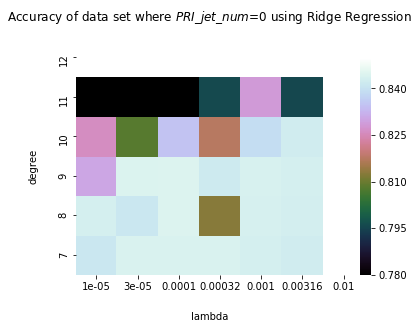

In [19]:
show_ridge_performance(results, degrees, lambdas, 0)

# Putting things together

In [20]:
# Degrees/lambda for each split of the dataset
degrees = [10, 12, 10, 10]
lambdas = [0.0001, 0.003, 0.003, 0.001]

# Creation of vector that will contain the predictions of the different splits
y_pred = np.zeros(len(y_test))

# Go over each split
for idx in range(len(masks_jet_train)):

    # Get split
    tx_train_selected_jet = tx_train[masks_jet_train[idx]]
    tx_test_selected_jet = tx_test[masks_jet_test[idx]]
    y_train_selected_jet = y_train[masks_jet_train[idx]]

    # Remove columns full of NaN
    tx_train_selected_jet = tx_train_selected_jet[:, ~np.all(np.isnan(tx_train_selected_jet), axis=0)]
    tx_test_selected_jet = tx_test_selected_jet[:, ~np.all(np.isnan(tx_test_selected_jet), axis=0)]

    # Remove columns without standard deviation at all
    tx_train_selected_jet = tx_train_selected_jet[:, np.nanstd(tx_train_selected_jet, axis=0) != 0]
    tx_test_selected_jet = tx_test_selected_jet[:, np.nanstd(tx_test_selected_jet, axis=0) != 0]
    
    # Replace remaining NaN by median
    tx_train_selected_jet = replace_nan_by_median(tx_train_selected_jet)
    tx_test_selected_jet = replace_nan_by_median(tx_test_selected_jet)

    # Standardize features
    mean_train_selected_jet, std_train_selected_jet, tx_train_selected_jet = standardize(tx_train_selected_jet)
    tx_test_selected_jet = standardize_predef(tx_test_selected_jet, mean_train_selected_jet, std_train_selected_jet)

    # Build poly
    tx_train_poly_selected_jet = build_poly_tx(tx_train_selected_jet, degrees[idx])
    tx_test_poly_selected_jet = build_poly_tx(tx_test_selected_jet, degrees[idx])
    
    # Compute best method
    w_selected_jet, _ = ridge_regression(y_train_selected_jet, tx_train_poly_selected_jet, lambdas[idx])

    # Compute accuracy (only used for printing)
    acc = accuracy(y_train_selected_jet, tx_train_poly_selected_jet, w_selected_jet, LOWER_BOUND, UPPER_BOUND)
    print("Accuracy of split %d:" % idx, acc)

    # pred of split + add it to the final pred
    y_test_pred = predict_labels(w_selected_jet, tx_test_poly_selected_jet, LOWER_BOUND, UPPER_BOUND)
    y_pred[masks_jet_test[idx]] = y_test_pred.flatten()

print("Number of %d:" % UPPER_BOUND, np.count_nonzero(y_pred == UPPER_BOUND))
print("Number of %d:" % LOWER_BOUND, np.count_nonzero(y_pred == LOWER_BOUND))

Accuracy of split 0: 0.844985137069
Accuracy of split 1: 0.809604869493
Accuracy of split 2: 0.839079775303
Accuracy of split 3: 0.845425013535
Number of 1: 178027
Number of -1: 390211


# Submission

In [21]:
create_csv_submission(ids_test, y_pred, "results.csv")

# Description of submissions

Test n : algorithm / features / y / w
- - - - - - - - - - - - - - - - - - - 
Test 1 : least_squares / all features standardized / y = -1,1 / random init_w

Test 2 : least_squares / corr > 0.1 features standardized / y = -1,1 / random init_w

Test 3 : least_squares_GD(10000,0.5) / all features standardized / y = -1,1 / random init_w

Test 4 : least_squares_GD(10000,0.5) / all features standardized / y = -1,1 / random init_w / poly, degree=1

Test 5 : least_squares / all features standardized / y = -1,1 / random init_w / median + categorical

Test 6 : logistic_regressoin  /all features standardized / y = 0,1 / random init_w / median + categorical + balanced

Test 7 : least_squares / all features standardized / y = 0,1 / random init_w

Test 8 : Test 1

Test 9 : Test 1

Test 10 : Test 1 / standardized test_set with mean and std from train_set

Test 11 : Test 1 / standardized test_set with mean and std from train_set / balance

Test 12 : Ridge regression / non-balanced / standardized test_set with mean and std from train_set / y=-1,1 / mean of 4 best lambdas for degree 11

Test 13 : Ridge regression / balanced / standardized test_set with mean and std from train_set / y=-1,1 / mean of 4 best lambdas for degree 11

Test 14 : Ridge regression / balanced before doing anything / standardized test_set with mean and std from train_set / y=-1,1 / mean of 4 best lambdas for degree 11

Test 15 : Ridge regression / Removed all rows containing at least a NaN / balanced before doing anything / standardized test_set with mean and std from train_set / y=-1,1 / mean of 4 best lambdas for degree 11 / Replaced NaN values in test_set by median in test_set

Test 16 : balanced before doing anything / standardized test_set with mean and std from train_set / y=-1,1 / Ensembling with: ("least_squares_GD", 1, 150, 0, 0.01, 0), ("least_squares_GD", 1, 50, 0, 0.25, 0), ("least_squares_SGD", 1, 30, 256, 0.2, 0), ("least_squares_SGD", 1, 60, 64, 0.1, 0), ("ridge_regression", 7, 0, 0, 0, 0.001), ("ridge_regression", 9, 0, 0, 0, 0.001), ("ridge_regression", 11, 0, 0, 0, 0.001)

Test 17 : balanced before doing anything / standardized test_set with mean and std from train_set / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [9, 11, 11, 11] and lambdas = [0.00046415888336127773, 0.001291549665014884, 4.6415888336127818e-05, 1.0000000000000001e-05]

Test 18 : non-balanced / standardized test_set with mean and std from train_set / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [9, 12, 12, 11] and lambdas = [4.6415888336127818e-05, 0.001, 0.0021544346900318821, 2.1544346900318823e-05]

Test 19 : non-balanced / standardized test_set with mean and std from train_set BUT AFTER SEPARATING / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [8, 12, 12, 11] and lambdas = [2.1544346900318823e-05, 0.0021544346900318821, 0.00046415888336127773, 0.0001]

Test 20 : balanced / standardized test_set with mean and std from train_set BUT AFTER SEPARATING / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [8, 13, 12, 10] and lambdas = [0.001, 0.001, 0.0021544346900318821, 0.001]

Test 21 : non-balanced / standardized test_set with mean and std from train_set BUT AFTER SEPARATING / y=-1,1 / Separating into 3 models based on feature 22, using Ridge everytime with degrees = [8, 12, 12] and lambdas = [2.1544346900318823e-05, 0.0021544346900318821, 0.00046415888336127773]

Test 22 : non-balanced / standardized test_set with mean and std from train_set BUT AFTER SEPARATING / y=-1,1 / Separating into 3 models based on feature 22, using Ridge everytime with degrees = [9, 12, 10] and lambdas = [4.6415888336127818e-05, 0.0021544346900318821, 0.00046415888336127773] / New features being inverse log

Test 23 : non-balanced / standardized test_set with mean and std from train_set / y=-1,1 / Separating into 3 models based on feature 22, using Ridge everytime with degrees = [10, 12, 10] and lambdas = [0.00021544346900318823, 0.00046415888336127773, 0.001] / New features being inverse log

Test 24 : non-balanced / standardized test_set with mean and std from train_set / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [10, 12, 9, 10] and lambdas = [0.00021544346900318823, 0.00046415888336127773, 1.0000000000000001e-05, 0.001] / New features being inverse log

Test 25 : balanced / standardized test_set with mean and std from train_set / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [11, 11, 10, 9] and lambdas = [0.0001, 3.1622776601683795e-05, 0.00031622776601683794, 0.01] / New features being inverse log

Test 26 : non-balanced / standardized test_set with mean and std from train_set BUT AFTER SEPARATING / y=-1,1 / Separating into 3 models based on feature 22, using Ridge everytime (unknown degrees and lambdas) / New features being inverse log

Test 27 : non-balanced / standardized test_set with mean and std from train_set / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [10, 12, 10, 10] and lambdas = [0.00021544346900318823, 0.0031622776601683794, 0.0031622776601683794, 0.001] / New features being inverse log

Test 28 : non-balanced / standardized test_set with mean and std from train_set / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [10, 12, 10, 10] and lambdas = [0.0001, 0.0031622776601683794, 0.001, 0.001] / New features being inverse log + pseudorapidity (eta)

Test 29 : non-balanced / standardized test_set with mean and std from train_set BUT AFTER SEPARATING / y=-1,1 / Separating into 4 models based on feature 22, using Ridge everytime with degrees = [10, 12, 10, 10] and lambdas = [0.0002, 0.003, 0.003, 0.001] / New features being inverse log

Test 30 : Test 26 with degrees = [11, 12, 10, 10] and lambdas = [0.00003, 0.003, 0.003, 0.001]

Test 31 : Test 26 with degrees = [10, 12, 10, 10] and lambdas = [0.0001, 0.003, 0.003, 0.001]